housing数据集:
经过训练后，进行回归的均方误差为: 0.14965497399416003


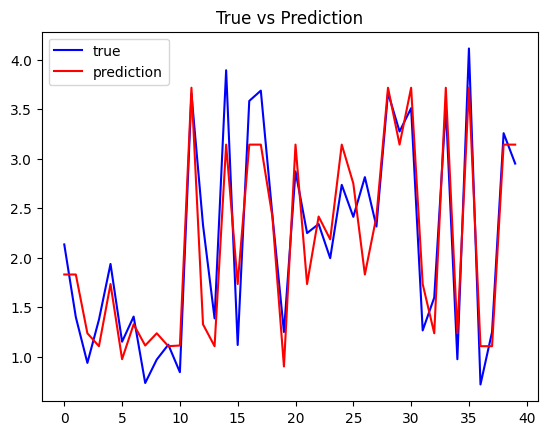


iceCream数据集数据集:
经过训练后，进行回归的均方误差为: 0.07210919975386244


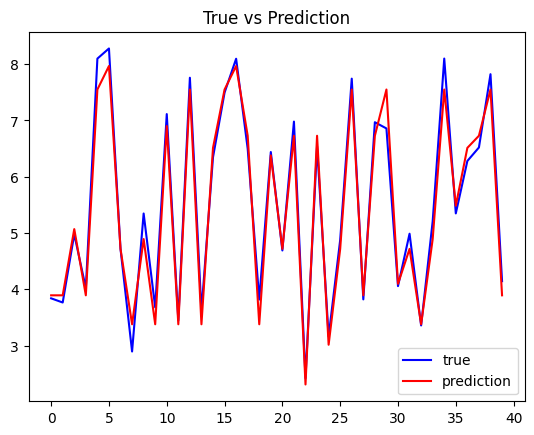

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as mtr
import matplotlib.pyplot as plt


# 定义结点类
class Node:
    def __init__(self, score=None):
        self.score = score
        self.feat_idx = None
        # 左右子树
        self.lc = None
        self.rc = None
        self.pos = None

        
# 二分数组，小于split的数据分到ret[0],大于split的数据分到ret[1]
def list_split(X, idxs, feature, split):
    ret = [[], []]
    while idxs:
        if X[idxs[0]][feature] < split:
            ret[0].append(idxs.pop(0))
        else:
            ret[1].append(idxs.pop(0))
    return ret


# 定义回归类
class Reg(object):

    def __init__(self):
        self.root = Node()
        self.depth = 0


    # 计算损失函数，此处以均方误差作为损失函数
    # data:特征矩阵 labels:类别 nums:样本数量 feat_idx:选择的特征下标 pos:该特征划分点  
    def get_loss(self, data, labels, nums, feat_idx, pos):
        split_sum = [0.0, 0.0]
        split_cnt = [0.0, 0.0]
        split_square_sum = [0.0, 0.0]
        # 对所有样本进行划分
        for i in nums:
            # 样本该特征的值和类别
            x, y = data[i][feat_idx], labels[i]
            if x < pos:
                split_cnt[0] += 1
                split_sum[0] += y
                split_square_sum[0] += y**2
            else:
                split_cnt[1] += 1
                split_sum[1] += y
                split_square_sum[1] += y**2
        # 计算loss
        split_average = [split_sum[0]/split_cnt[0], split_sum[1]/split_cnt[1]]
        split_loss = [split_square_sum[0] - split_sum[0]*split_average[0],
                     split_square_sum[1] - split_sum[1]*split_average[1]]
        return sum(split_loss), pos, split_average

    
    # description: 获取最优划分
    # data:特征矩阵 labels:类别 rows:样本数量列表 feat_idx:特征索引
    def get_best_split(self, data, labels, nums, feat_idx):
        ss = set([data[i][feat_idx] for i in nums])
        if len(ss) == 1:
            return None
        # 无分割
        ss.remove(min(ss))
        # 获取最优划分
        loss, pos, split_average = min((self.get_loss(
            data, labels, nums, feat_idx, pos) for pos in ss), key=lambda x: x[0])
        return loss, feat_idx, pos, split_average


    # 获取最优属性
    def get_best_feature(self, data, labels, idx):
        length = len(data[0])
        split_rets = map(lambda j: self.get_best_split(data, labels, idx, j), range(length))
        split_rets = filter(lambda x: x is not None, split_rets)
        return min(split_rets, default=None, key=lambda x: x[0])

 
    # 回归函数
    def regress(self, data, labels, max_depth=5, min_samples_split=2):
        idxs = list(range(len(labels)))
        q = [(self.depth + 1, self.root, idxs)]
        while q:
            depth, node, idx = q.pop(0)
            # 超过最大深度，停止循环，防止过拟合
            if depth > max_depth:
                depth -= 1
                break
            # 节点属于同一类别
            if len(idx) < min_samples_split or set(map(lambda i: labels[i], idx)) == 1:
                continue
            split_ret = self.get_best_feature(data, labels, idx)
            if split_ret == None:
                continue
            _, feat_idx, pos, split_average = split_ret
            # 更新当前节点属性
            node.feat_idx = feat_idx
            node.pos = pos
            node.lc = Node(split_average[0])
            node.rc = Node(split_average[1])
            # 当前节点的子节点放入队列中
            idx_list = list_split(data, idx, feat_idx, pos)
            q.append((depth + 1, node.lc, idx_list[0]))
            q.append((depth + 1, node.rc, idx_list[1]))
        self.depth = depth

        
    # 预测函数
    def prediction(self, x_test):
        pred = []
        for x in x_test:
            node = self.root
            while node.lc != None and node.rc != None:
                if x[node.feat_idx] < node.pos:
                    node = node.lc
                else:
                    node = node.rc
            pred.append(node.score)      
        return pred

    
# 画真实值和预测值的折线图
def drawResult(x, y_pred, y_true):
    plt.figure()
    x = range(len(y_true))
    plt.plot(x, y_true, color='b', label='true')
    plt.plot(x, y_pred, color='r', label='prediction')
    plt.title('True vs Prediction')
    plt.legend()
    plt.show()


if __name__ == "__main__":
    # housing数据集
    data = pd.read_excel("housing.xlsx",engine='openpyxl')
    X = data.iloc[:200, :-1].values
    y = data.iloc[:200, -1].values
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    reg = Reg()
    reg.regress(x_train, y_train, max_depth=5)
    y_pred = reg.prediction(x_test)
    loss = mtr.mean_squared_error(y_test, y_pred)
    print("housing数据集:")
    print("经过训练后，进行回归的均方误差为: {}".format(loss))
    drawResult(x_test, y_pred, y_test)

    # iceCream数据集
    data = pd.read_excel("iceCream.xlsx",engine='openpyxl')
    X = data.iloc[:200, :-1].values*0.01
    y = data.iloc[:200, -1].values*0.01
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    reg = Reg()
    reg.regress(x_train, y_train, max_depth=5)
    y_pred = reg.prediction(x_test)
    loss = mtr.mean_squared_error(y_test, y_pred)
    print("\niceCream数据集数据集:")
    print("经过训练后，进行回归的均方误差为: {}".format(loss))
    drawResult(x_test, y_pred, y_test)